<a name="Top"></a>
<p><span style="font-size: 30px;"><strong>BQL</strong></span><strong><br></strong><span style="text-align: inherit; font-size: 28px;"><strong><span style="color: orange;">Fixed Income - PCA </span></strong></span></p>


<div style="background-color: #232323; padding: 10px 25px">    
<h2><span style="color:orange"> Yield Curve Decomposition using PCA </span></h2>
    
<ul>
    <li> Understanding Principal Components and Residuals
    <li> Trading Residuals or Principal Components
    <li> Risk Scenarios Simulation using Principal Components
</ul>
    
</div>


<p><strong><span style="color: orange; font-size: 24px;"> Step 1: Import libraries </span></strong></p>


In [2]:
import bql
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import itertools
import statsmodels.tsa.stattools as ts
%load_ext autoreload
%autoreload 2

In [3]:
bq = bql.Service()


<p><strong><span style="color: orange; font-size: 24px;"> Step 2 : BQL to pull yield for PCA</span></strong></p>
<p><span style="font-size: 20px;"> Use BQL to pull yield of treasuries over history </span></p>

###### 'US': ['USGG3M Index','USGG6M Index','USGG12M Index','USGG2YR Index','USGG3YR Index','USGG5YR Index','USGG7YR Index','USGG10YR Index','USGG30YR Index']

In [4]:
ctry_dict = {
    
    'US': ['USGG3M Index','USGG6M Index','USGG12M Index','USGG2YR Index','USGG3YR Index','USGG5YR Index','USGG7YR Index','USGG10YR Index','USGG30YR Index'],
    # 'EU': ['GECU3M Index','GECU6M Index','GECU1YR Index','GECU2YR Index','GECU3YR Index','GECU5YR Index','GECU7YR Index','GECU10YR Index','GECU30YR Index'],
    # 'JP': ['GTJPY3M Govt','GTJPY6M Govt','GTJPY12M Govt','GTJPY2YR Govt','GTJPY3YR Govt','GTJPY5YR Govt','GTJPY7YR Govt','GTJPY10YR Govt','GTJPY30YR Govt'],
}

tenor_dict = {
    'US': ['3M', '6M', '12M', '2YR', '3YR', '5YR', '7YR', '10YR', '30YR']
    
}

In [5]:
tenor_list = ctry_dict['US']

#retrieve universe with bq.univ.list(tenor_list)
uni = bq.univ.list(tenor_list)
#data to be historical yields from 2019-01-01 till today
fld = {'yield':bq.data.px_last(dates=bq.func.range('2019-01-01',bq.func.today()))}
req = bql.Request(uni,fld)
resp = bq.execute(req)
df1 = resp[0].df()

df = df1.set_index('DATE',append=True)['yield']
df = df.unstack().T
df = df.dropna(how='all')[tenor_list]
# pandas's .interpolate to fill it NaN values
df = df.interpolate(method='linear', axis=0).ffill()

#### Put it as a function for ease of manipulation

In [6]:
def get_data_for_cntry(ctry):
    tenor_list = ctry_dict[ctry]
    uni = bq.univ.list(tenor_list) #generic US tenors yields
    fld = {'yield':bq.data.px_last(dates=bq.func.range('2019-01-01','2024-03-15'))}
    req = bql.Request(uni,fld)
    resp = bq.execute(req)
    df1 = resp[0].df()
    df = df1.set_index('DATE',append=True)['yield']
    df = df.unstack().T
    df = df.dropna(how='all')[tenor_list] #holidays
    df = df.interpolate(method='linear', axis=0).ffill()
    return tenor_list, df

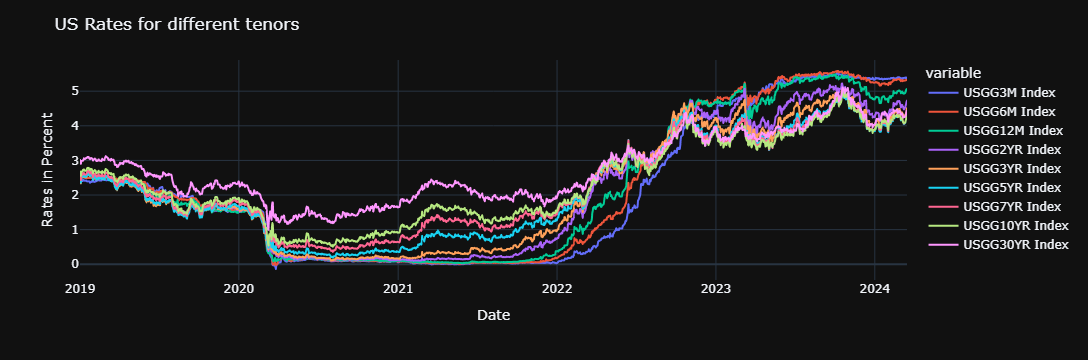

In [7]:
indices, df = get_data_for_cntry('US')
px.line(data_frame=df.reset_index(), y = indices, x='DATE',template='plotly_dark').update_layout(title = 'US Rates for different tenors', xaxis_title="Date", yaxis_title="Rates in Percent")

<p><strong><span style="color: orange; font-size: 24px;"> Step 3 : PCA with sklearn</span></strong></p>

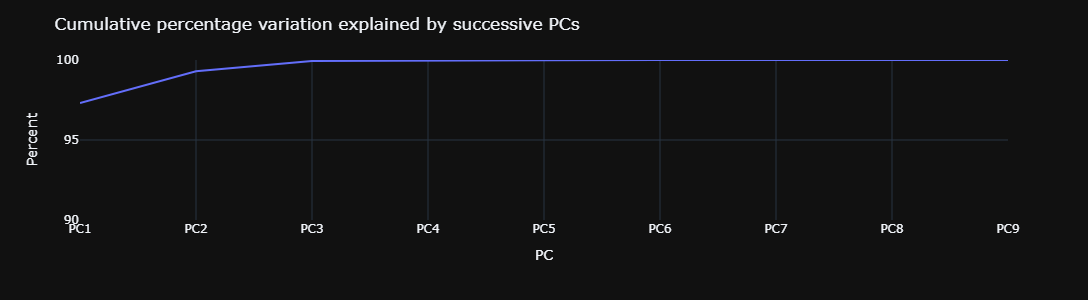

In [8]:
#Step1: We perform standardization to get a scaled data.
# Standardize the data values into a standard format
scaler = StandardScaler()
df_normalized_mean = pd.DataFrame(scaler.fit_transform(df),columns=df.columns,index=df.index)
instruments = df.columns
#Step2: We calculate the PCA using fit_transform
pca = PCA(n_components=len(instruments))
YC_PCA = pca.fit_transform(df_normalized_mean)
#Step3: Create a SCREE plot to check the weights of each component
pc_var = pd.Series(pca.explained_variance_ratio_.cumsum()*100, index = ['PC'+str(i) for i in range(1,10)])
px.line(pc_var, template='plotly_dark').update_layout \
                        (title = 'Cumulative percentage variation explained by successive PCs', xaxis_title="PC", yaxis_title="Percent", yaxis_range=[90,100], showlegend=False, width=600, height=300)

In [9]:
#Getting signs correct for further interpretability
pc_dir = pd.concat([pd.Series(pca.components_[i]) for i in range(0,3)],axis=1,keys=['PC1 (level)','PC2 (slope)','PC3 (curvature)'])
pc_dir.index = tenor_dict['US']

df_PC = pd.DataFrame(YC_PCA,columns=[i for i in range(0,9)],index = df.index)

if pc_dir.iloc[-1,1] < 0:
    pc_dir.iloc[:,1] = -1 * pc_dir.iloc[:,1]
    df_PC[1] = -1 * df_PC[1]

if pc_dir.iloc[-1,2] < 0:
    pc_dir.iloc[:,2] = -1 * pc_dir.iloc[:,2]
    df_PC[2] = -1 * df_PC[2]

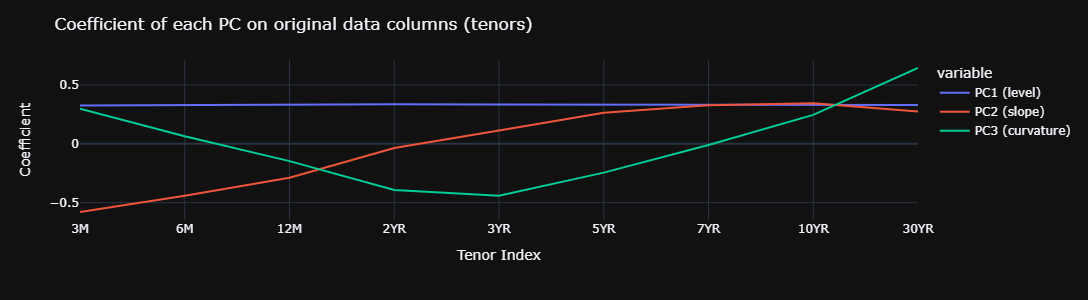

In [10]:
px.line(data_frame= pc_dir, template='plotly_dark', width=100).update_layout \
                        (title = 'Coefficient of each PC on original data columns (tenors)', xaxis_title="Tenor Index", yaxis_title="Coefficient", showlegend=True, width=600, height=300)

<h2><font color='orange'> Interpreting first 3 PCs</font> </h2>

<div style="background-color: #232323; padding: 10px 25px">    
<h4><span style="color:orange"> PC1 / Level: </span></h4>
    
<ul>
<li>The first principal component often captures the overall level of interest rates across all maturities. It is highly correlated with 'level' of rates.
<li>A positive loading on this component suggests a parallel upward or downward shift in the yield curve, indicating changes in short-term interest rates, influenced by factors such as central bank policy, inflation expectations, or economic growth
<li>Higher absolute values of loadings indicate higher sensitivity to changes in interest rates across maturities.
<li>Significance: It represents the common factor that affects all maturities and is often associated with changes in monetary policy or broad economic conditions.
</ul>
    
</div>

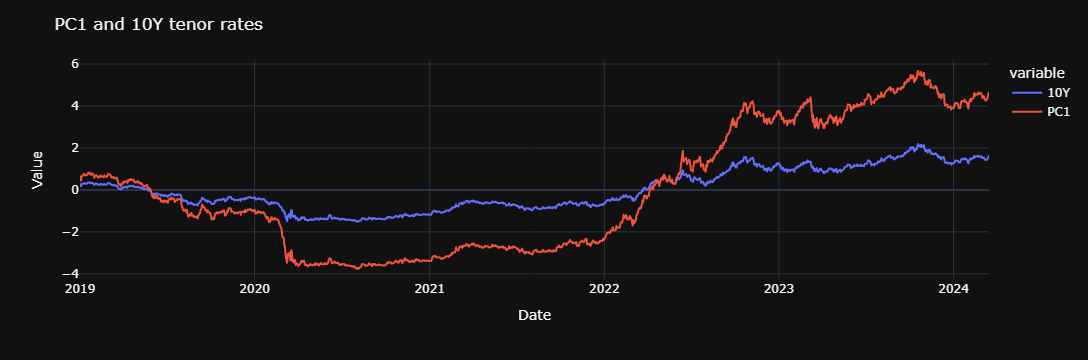

10Y      PC1
10Y  1.00000  0.98727
PC1  0.98727  1.00000

In [17]:
p1 = pd.concat([pd.Series(df_normalized_mean['USGG10YR Index'].values, index=df.index),df_PC[0]], axis=1, keys = ['10Y','PC1'])
display(px.line(data_frame= p1, template='plotly_dark').update_layout(title = 'PC1 and 10Y tenor rates', xaxis_title="Date", yaxis_title="Value", showlegend=True))
display(p1.corr())

<div style="background-color: #232323; padding: 10px 25px">    
<h4><span style="color:orange"> PC2 / Slope </span></h4>
<ul>
<li> The second principal component typically captures the slope or steepness of the yield curve.
<li> Positive loadings on this component imply a steepening yield curve, where long-term rates rise relative to short-term rates, suggesting expectations of future economic expansion or inflation.
<li> Negative loadings indicate a flattening yield curve, where long-term rates fall relative to short-term rates, signaling expectations of economic slowdown or deflationary pressures.
<li> Significance: It reflects changes in market expectations regarding future interest rate movements, inflation, or economic growth dynamics.
</ul>
    
</div>

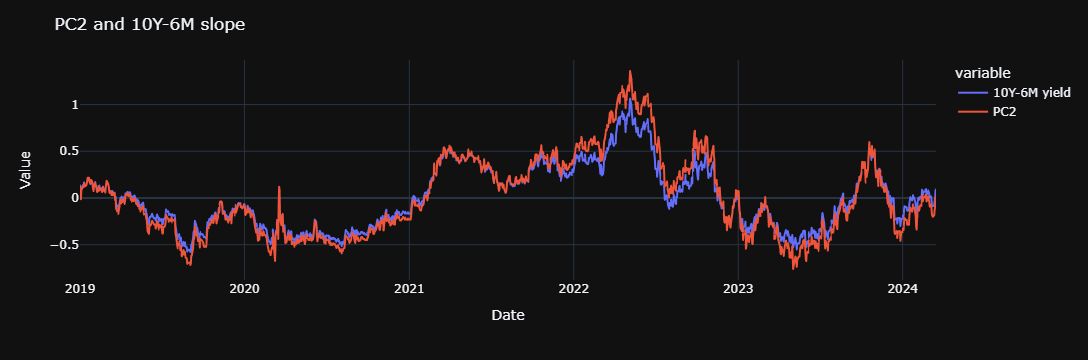

10Y-6M yield     PC2
10Y-6M yield        1.0000  0.9887
PC2                 0.9887  1.0000

In [39]:
p2 = pd.concat([pd.Series((df_normalized_mean['USGG10YR Index'] - df_normalized_mean['USGG6M Index']).values, index=df.index),df_PC[1]], axis=1, keys = ['10Y-6M yield','PC2'])
display(px.line(data_frame= p2, template='plotly_dark').update_layout \
                        (title = 'PC2 and 10Y-6M slope', xaxis_title="Date", yaxis_title="Value", showlegend=True))
display(p2.corr())

<div style="background-color: #232323; padding: 10px 25px">    
<h4><span style="color:orange"> PC3 / Curvature </span></h4>
<ul>
<li> The third principal component represents the curvature or shape of the yield curve beyond level and slope changes.
<li> Positive loadings on this component imply a "butterfly" shape, where intermediate-term rates are relatively higher or lower compared to short and long-term rates.
<li> Negative loadings indicate a more traditional convex or concave curve shape.
<li> Significance: It captures more nuanced changes in interest rate expectations, such as market sentiment regarding intermediate-term economic conditions, yield curve strategies, or specific market shocks.
</ul>
</div>

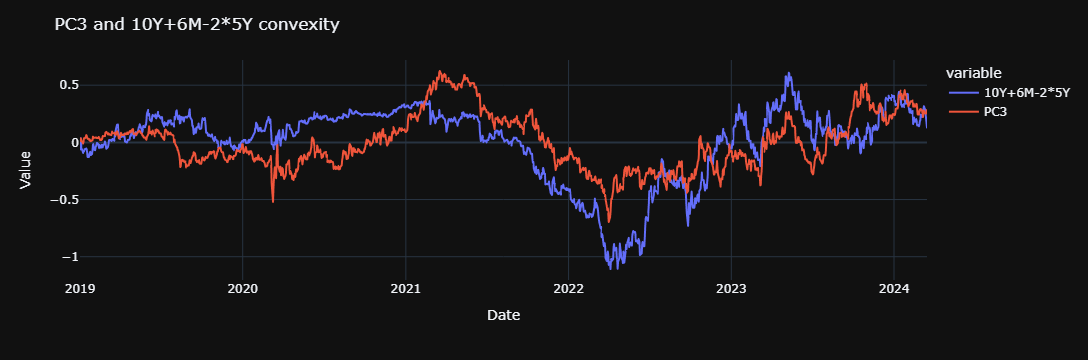

10Y+6M-2*5Y      PC3
10Y+6M-2*5Y      1.00000  0.58176
PC3              0.58176  1.00000

In [18]:
p3 = pd.concat([pd.Series((df_normalized_mean['USGG10YR Index'] + df_normalized_mean['USGG6M Index'] - 2*df_normalized_mean['USGG5YR Index']).values, index=df.index),df_PC[2]], axis=1, keys = ['10Y+6M-2*5Y','PC3'])
display(px.line(data_frame= p3, template='plotly_dark').update_layout \
                        (title = 'PC3 and 10Y+6M-2*5Y convexity', xaxis_title="Date", yaxis_title="Value", showlegend=True))
display(p3.corr())

<h1><font color='orange'> Reconstruction of yield curve from first 3 PCs </font></h1>

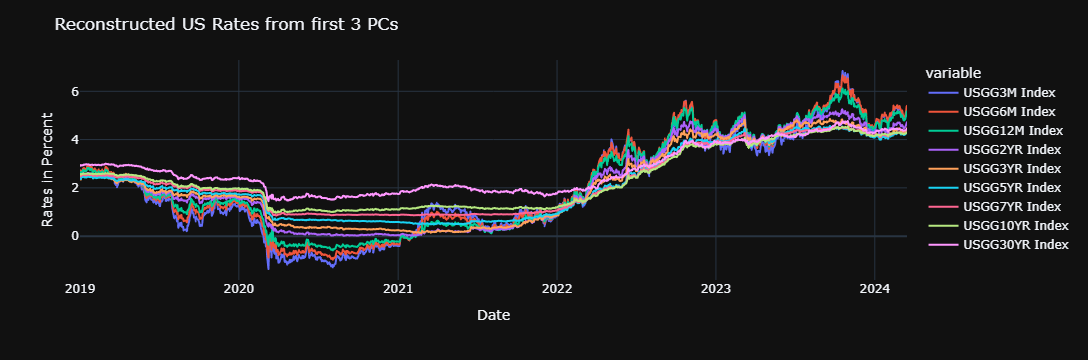

In [41]:
rescaledDataset = YC_PCA
num_components = 3
reconstructed_df = pd.DataFrame(data=scaler.inverse_transform(np.dot((YC_PCA)[:,:num_components],pca.components_[:num_components,:])),columns=df.columns,index = df.index)

px.line(data_frame = reconstructed_df.reset_index(), y = indices, x='DATE',\
        template='plotly_dark').update_layout(title = ' Reconstructed US Rates from first 3 PCs', xaxis_title="Date", yaxis_title="Rates in Percent")

<h2><font color='orange'> Use case 1 : Difference between actual rates and reconstructed rates measures relative richness / cheapness in the curve </font></h2>

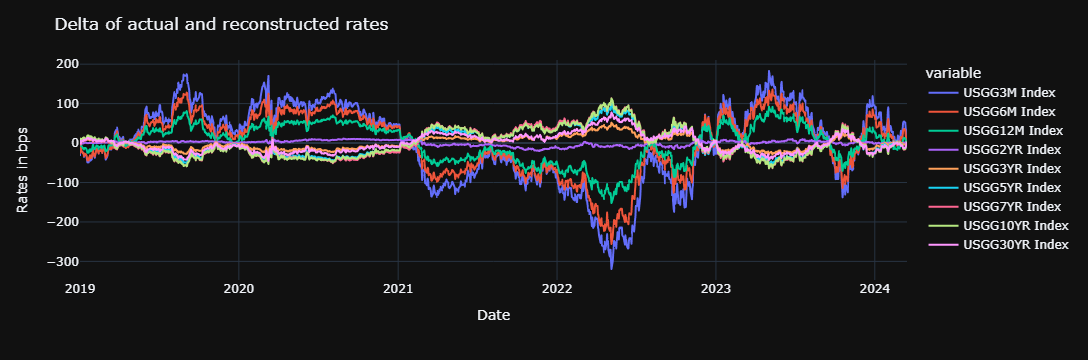

In [42]:
resid_df = (df - reconstructed_df)*100
px.line(data_frame = resid_df.reset_index(), y = indices, x='DATE',\
        template='plotly_dark').update_layout(title = 'Delta of actual and reconstructed rates', xaxis_title="Date", yaxis_title="Rates in bps")

<h2><font color='orange'> Use Case 2: Simulated Scenarios for Risk Analysis </font></h2>
We shock first 3 PCs (using their historical 5 percentile and 95 percentile diffs) and reconstruct the entire yield curve with the new PCs. This gives us more realistic scenarios that just plainly shocking the whole rate curve up and down, as it takes into account the correlation between different parts of the curve. This is very valuable for risk forecasting purposes.

In [20]:
s = df_PC[0].diff()
down_shock, up_shock = s[s < s.quantile(0.05)].mean(), s[s > s.quantile(0.95)].mean()
pc1 = [ YC_PCA[-1][0] + down_shock , YC_PCA[-1][0],  YC_PCA[-1][0] + up_shock ]

s = df_PC[1].diff()
down_shock, up_shock = s[s < s.quantile(0.05)].mean(), s[s > s.quantile(0.95)].mean()
pc2 = [ YC_PCA[-1][1] + down_shock , YC_PCA[-1][1],  YC_PCA[-1][1] + up_shock ]

s = df_PC[2].diff()
down_shock, up_shock = s[s < s.quantile(0.05)].mean(), s[s > s.quantile(0.95)].mean()
pc3 = [ YC_PCA[-1][2] + down_shock , YC_PCA[-1][2],  YC_PCA[-1][2] + up_shock ]

In [44]:
product_mat = list(itertools.product(pc1,pc2,pc3))
#labels
direc = ['down','hold','up']
direc_lbl = list(itertools.product(['PC1_'+x for x in direc],['PC2_'+x for x in direc],['PC3_'+x for x in direc]))
direc_lbl = [str(x) for x in direc_lbl]

In [45]:
scenario_df = pd.DataFrame(data=scaler.inverse_transform(np.dot(pd.DataFrame(product_mat).to_numpy()[:,:num_components],pca.components_[:num_components,:])), columns=df.columns, index = direc_lbl)

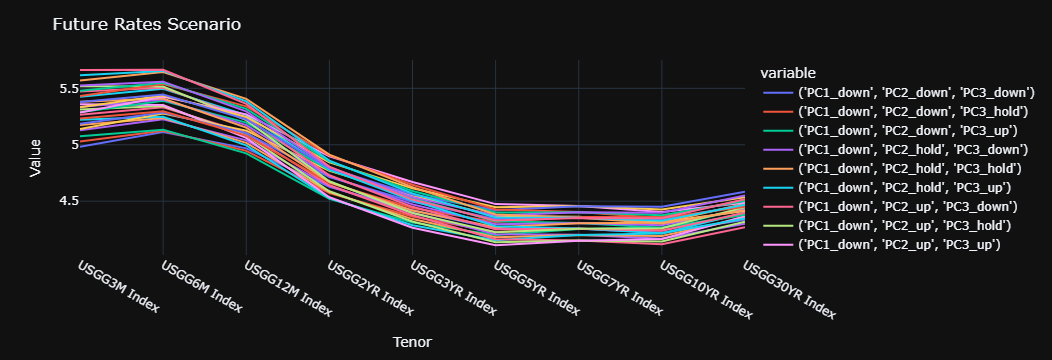

In [46]:
display(px.line(data_frame= scenario_df.T, template='plotly_dark').update_layout \
                        (title = 'Future Rates Scenario', xaxis_title="Tenor", yaxis_title="Value", showlegend=True))